$$
% transferring macros:
\let\eps\varepsilon
\let\wt\widetilde
\let\tn\mathrm
\let\vphi\varphi
\let\pa\partial
\let\para\parallel
\let\wh\widehat
\let\sl\shoveleft
% defining new macros:
\def\be{\begin{equation} \mskip 1cm}
\def\ee{\end{equation}}
\def\ba{\begin{align} \mskip 1cm}
\def\ea{\end{align}}
\def\RR{{\mathbb R}}
\def\DD{{\mathbb D}}
\def\GG{{\mathbb G}}
\def\CC{{\mathbb C}}
\def\MM{{\mathbb M}}
\def\JJ{{\mathbb J}}
\def\WW{{\mathbb W}}
\def\HH{{\mathbb H}}
\def\SS{{\mathbb S}}
\def\QQ{{\mathbb Q}}
\def\BB{{\mathbb B}}
\def\grad{\tn{grad}\,}
\def\curl{\tn{curl}\,}
\def\unit{\mathbb 1}
\def\div{\tn{div}\,}
\def\Im{\tn{Im}}
% defining new commands:
\newcommand{\abs}[1]{\lvert#1\rvert}
\newcommand{\bold}[1]{{\bf #1}}
\newcommand{\pder}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\dt}[1]{\frac{\mathrm d #1}{\mathrm dt}}
\newcommand{\ds}[1]{\frac{\mathrm d #1}{\mathrm ds}}
$$

# Vlasov-Maxwell equations with finite element exterior calculus

## Maxwell equations in 3D

The aim of this notebook is to explain the finite element discretization of Maxwell's equations based on finite element exterior calculus (FEEC), coupled to a particle-in-cell (PIC) solver for the Vlasov equation. FEEC is based on the de Rham complex of finite element spaces: 

<img src="pics/deRham.png" width="550"/> 

This complex is used in the discretization of Maxwell's equations for the electric field $\bold E$ and the magnetic field $\bold B$:

$$
\ba
 \frac{1}{c^2} \pder{\bold E}{t} - \curl \bold B &= - \mu_0\bold J &&\qquad\quad\tn{(Ampère)} \,, \label{ampere}
 \\[1mm]
 \pder{\bold B}{t} + \curl \bold E &= 0 &&\qquad\quad\tn{(Faraday)} \,,
 \\[1.5mm]
 \div \bold E &= \frac{\varrho}{\eps_0} &&\qquad\quad\tn{(Gauss\,1)} \,, \label{gauss}
 \\[2mm]
 \div \bold B &= 0 &&\qquad\quad\tn{(Gauss\,2)} \,. \label{divB}
\ea
$$

Here, $\bold J$ and $\varrho$ are the given sources, namely the current density and the charge density, respectively. Natural constants are the speed of light $c$, the magnetic constant $\mu_0$ and the dielectric constant $\eps_0$, where $1/c^2 = \eps_0\mu_0$. Taking the divergence of Ampère's law \eqref{ampere}, using that $\div\curl = 0$ and inserting Gauss' law \eqref{gauss} yields

$$
\be
 \pder{\varrho}{t} + \div \bold J = 0\,. \label{charge}
\ee
$$

This is a solvability condition for Maxwell's equations, called "conservation of charge". On the other hand, taking the time derivative of the Gauss law \eqref{gauss}, equation \eqref{charge} implies

$$
\be \label{alltimes}
 \dt{} \left( \div \bold E - \frac{\varrho}{\eps_0} \right) =  \frac{1}{\eps_0\mu_0}\, \div \curl \bold B - \frac{1}{\eps_0} \div \bold J - \frac{1}{\eps_0} \pder{\varrho}{t} = 0\,,
\ee
$$

Similarly,

$$
\be
 \dt{}\, \div \bold B = - \div \curl \bold E = 0\,,
 \ee
$$

which means that the two Gauss laws are satisfied at all times provided that they are satisfied at the initial time. The commuting diagram property of the deRham complex allows for numerical schemes that translate this property to the discrete level exactly (up to machine precision).

## 1D test problem

Let us start with the one dimensional case (1D). For this we assume that variations of $\bold E$ and $\bold B$ occur only with respect to the $x$-direction, hence

$$
\be
 \grad = \begin{pmatrix} \pder{}{x} \\ 0 \\ 0  \end{pmatrix} \,,\qquad \curl \bold E = \begin{pmatrix} 0 \\ -\pder{E_z}{x} \\ \pder{E_y}{x} \end{pmatrix}\,,\qquad \div \bold E = \pder{E_x}{x}\,.
\ee
$$

Moreover, let us assume $E_z = B_x = B_y = 0$ and denote $E := E_y$, $J:= J_y$ and $B:= B_z$. Maxwell's equations then read

$$
\ba
 &\frac{1}{c^2} \pder{E_x}{t} = - \mu_0 J_x &&\qquad\quad\tn{(Ampère\,first\,component)} \,, \label{ampere:1Dx}
 \\[1mm]
 &\frac{1}{c^2} \pder{E}{t} + \pder{B}{x} = - \mu_0 J &&\qquad\quad\tn{(Ampère\,second\,component)} \,, \label{ampere:1D}
 \\[1mm]
 &\pder{B}{t} + \pder{E}{x} = 0 &&\qquad\quad\tn{(Faraday)} \,, \label{faraday:1D}
 \\[1mm]
 & \pder{E_x}{x} = \frac{\varrho}{\eps_0} &&\qquad\quad\tn{(Gauss 1)} \,, \label{gauss1:1D}\,.
\ea
$$

We assume the domain to be $\Omega = (a,b)$ and suppose homogeneous Dirichlet boundary conditions for $E$ and periodic conditions for $E_x$. In order to obtain a weak formulation of \eqref{ampere:1Dx}-\eqref{gauss1:1D} we multiply by test functions $F_x$, $F$, $C$ and $D$ and integrate over $\Omega$:

$$
\ba
 &\frac{1}{c^2} \int_a^b \pder{E_x}{t} F_x\,\tn d x = - \mu_0 \int_a^b J_x F_x\,\tn d x\,, \label{int:1}
 \\[1mm]
 &\frac{1}{c^2} \int_a^b \pder{E}{t} F\,\tn d x + \int_a^b \pder{B}{x} F\,\tn d x = - \mu_0 \int_a^b J \,F\,\tn d x\,, 
 \\[1mm]
 &\int_a^b \pder{B}{t} C\,\tn d x + \int_a^b \pder{E}{x} C\,\tn d x = 0\,, \label{int:3}
 \\[1mm]
 &\int_a^b \pder{E_x}{x} D \,\tn d x = \frac{1}{\eps_0} \int_a^b \varrho\,D\,\tn d x\,. \label{int:4}
\ea
$$

There are multiple possibilities to use this for a weak formulation of \eqref{int:1}-\eqref{int:3}. We choose the following: find $(E_x,E,B)\in H^1\times H^1_0 \times L^2$ such that

$$
\ba
 &\frac{1}{c^2} \int_a^b \pder{E_x}{t} F_x\,\tn d x = - \mu_0 \int_a^b J_x F_x\,\tn d x \qquad &&\forall\, F_x \in H^1\,, \label{weak:1}
 \\[1mm]
 &\frac{1}{c^2} \int_a^b \pder{E}{t} F\,\tn d x - \int_a^b B\,\pder{F}{x} \,\tn d x = - \mu_0 \int_a^b J \,F\,\tn d x \qquad &&\forall\, F \in H^1_0\,, 
 \\[1mm]
 &\int_a^b \pder{B}{t} C\,\tn d x + \int_a^b \pder{E}{x} C\,\tn d x = 0 \qquad &&\forall\, C \in L^2\,, \label{weak:3}
 \\[1mm]
 &\int_a^b \pder{E_x}{x} D \,\tn d x = \frac{1}{\eps_0} \int_a^b \varrho\,D\,\tn d x \qquad &&\forall\, D \in L^2\,. \label{weak:4}
\ea
$$

Remark that we integrated by parts in the second equation in order to obtain a well defined weak formulation. 

## Space discretization

The problem \eqref{weak:1}-\eqref{weak:4} contains only first order derivatives. Our aim is to choose solution spaces that satisfy a commuting diagram. A simpler 1D version of the above deRham complex reads as follows:

<img src="pics/deRham1D.png" width="220"/>

The projectors $\Pi_0$ and $\Pi_1$ must be chosen such that the diagram is commuting. In particular, for the discrete solution spaces we have $V_0 \subset H^1_0$ and $V_1 \subset L^2$ with $\dim V_0 = N_0 <\infty$ and $\dim V_1 = N_1 < \infty$. The basis functions will be denoted by $(\varphi^0_i)_{1\leq i\leq N_0}$ and $(\varphi^1_{i+1/2})_{0\leq i\leq N_1-1}$, respectively. For periodic boundary conditions we consider a similar diagram with the appropriate spaces and denote everything with a tilde, for example, $\tilde V_0$. The discrete version of problem \eqref{weak:1}-\eqref{weak:3} reads: find $(E_{x,h},E_h,B_h)\in \tilde V_0\times V_0 \times V_1$ such that

$$
\ba
 &\frac{1}{c^2} \int_a^b \pder{E_{x,h}}{t} F_{x,h}\,\tn d x = - \mu_0 \int_a^b (\tilde \Pi_0 J_x) F_{x,h}\,\tn d x \qquad &&\forall\, F_{x,h} \in \tilde V_0\,, \label{disc:1}
 \\[1mm]
 &\frac{1}{c^2} \int_a^b \pder{E_h}{t} F_h\,\tn d x - \int_a^b B_h\,\pder{F_h}{x} \,\tn d x = - \mu_0 \int_a^b J \,F_h\,\tn d x \qquad &&\forall\, F_h \in V_0\,, 
 \\[1mm]
 &\int_a^b \pder{B_h}{t} C_h\,\tn d x + \int_a^b \pder{E_h}{x} C_h\,\tn d x = 0 \qquad &&\forall\, C_h \in V_1\,, \label{disc:3}
 \\[1mm]
 &\int_a^b \pder{E_{x,h}}{x} D_h \,\tn d x = \frac{1}{\eps_0} \int_a^b (\Pi_1\varrho)\,D_h\,\tn d x \qquad &&\forall\, D_h \in V_1\,. \label{disc:4}
\ea
$$


We shall implement Lagrange finite elements ourselves and use Ahmed's library 'spl' for spline finite elements.



A first important step is to define the mesh over the domain $\Omega = (a,b)$. The domain will be split into $N_\tn{el}$ elements, denoted $\Omega_k$, such that $\Omega = \cup_{k = 1}^{N_\tn{el}} \Omega_k$ and $\Omega_k \cap \Omega_{k+1} = c_k$, where $(c_k)_{1\leq k\leq N_\tn{el}-1}$ denote the element interfaces (or boundaries). The domain boundaries are denoted by $c_0 = a$ and $c_{N_\tn{el}} = b$.  

### Lagrange shape functions 

The bases for $V_0$ and $V_1$ are most conveniently defined by means of a  reference element (or patch). The convention is to use $I = [-1, 1]$ as the patch and to define the mappings $F_k: I \to \Omega_k$, $s\in[-1,1]\mapsto x\in[c_{k-1}, c_k]$ and its inverse, respectively:

$$
 \ba
  x &= F_k(s) := c_{k-1} + \frac{s + 1}{2}(c_k - c_{k-1})\,, \label{F}
  \\[1mm]
  s &= F_k^{-1}(x) := \frac{2\,(x - c_{k-1})}{c_k - c_{k-1}} - 1\,. \label{Finv}
 \ea
$$

Let us first consider the space $V_0 \subset H_0^1$. Its elements being continuous functions, the usual Lagrange basis is a valid choice. Lagrange shape functions (polynomials) of degree $d$ will be created on the reference element from a sequence of knots $s_0 = -1 < \ldots < s_d = 1 \in I$. They are defined by 

$$
\be
 \eta_n(s_m) = \delta_{n,m}\,,\qquad n,\, m = 0,\ldots, d\,,   \label{def:Lag}
\ee
$$

which leads to the formula

$$
\be
 \eta_n(s) = \prod_{m\neq n} \frac{s - s_m}{s_n - s_m}\,.
\ee
$$

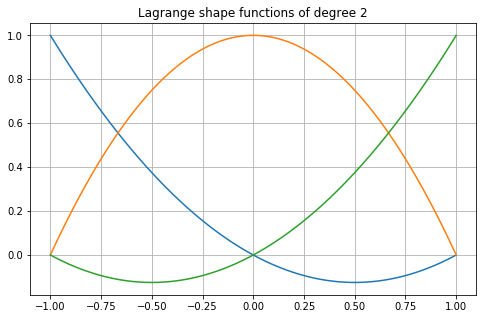

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import fixed_quad
import fembase as fem

degree = 2
# polynomial degree
shapefun = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))
# check the docstring to see what this does
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
svec = np.linspace(-1,1,100)

for i in range(shapefun.d + 1):
    ax.plot(svec, shapefun.eta[i](svec))
    
ax.grid()
ax.set(title='Lagrange shape functions of degree ' + str(shapefun.d))
plt.show()

The actual basis functions $\varphi_i^0$ are related to the shape functions $\eta_n$ via the mappings $F_i$ from \eqref{F}-\eqref{Finv}. Since there are many different indices involved, let us clarify:

$$
\ba
 &\tn{elements:} &&\Omega_k, \quad k = 1,\ldots, N_\tn{el} \,,
 \\[2mm]
 &\tn{basis\,functions:} &&\varphi_i^0,\quad i = 1, \ldots, N_0\,,
 \\[2mm]
 &\tn{shape\,functions:} &&\eta_n,\quad n = 0,\ldots, d\,.
\ea
$$

Let us compute the number $N_0$ of Lagrange basis functions for the space $V_0$. In each element we have $d+1$ shape functions, such that the total number of degrees of freedom (DOF) is $N_\tn{tot} = N_\tn{el}(d+1)$. In order to guarantee continuity, the element interfaces must be shared degrees of freedom and are only counted once. Hence, the number of basis functions is $N_0 = N_\tn{tot} - (N_\tn{el} - 1) - bcs$, where $bcs$ depends on the boundary conditions. For homogeneous Dirichlet conditions we remove the leftmost and the rightmost DOF, thus $bcs = 2$. For periodic conditions no DOF is removed, but the first and the last DOF are shared, thus $bcs = 1$. The relation between the different indices is described in the following tables.

Table 1: <b>Dirichlet boundary conditions</b> ($bcs = 2$), $\quad N_0 = N_\tn{el}d - 1$.

$$
 \begin{array}{c|c|c}
 \tn{element} & \tn{basis\,function} & \tn{shape\, function}
 \\[0mm]
 k & i & n
 \\[1mm] \hline
 1 & 1,\ldots, d  & 1,\ldots,d 
 \\[1mm]
 2 & d,\ldots, 2d & 0,\ldots,d
 \\[1mm]
 \vdots & \vdots & \vdots
 \\[1mm]
 k & (k-1)d,\ldots, kd  & 0,\ldots,d
 \\[1mm]
 \vdots & \vdots & \vdots
 \\[1mm]
 N_\tn{el} & (N_\tn{el} - 1)d,\ldots, N_\tn{el}d - 1 & 0,\ldots,d - 1
 \end{array}\,.
$$

This means that in the first element we have the basis functions $\varphi_i^0$ with the indices $i = n $ for $n = 1,\ldots,d$, in the $k$-th element ($1 < k < N_\tn{el}$) we have the basis functions $i = (k-1)d + n$ with $n = 0,\ldots,d$ and in the $N_\tn{el}$-th element we have the basis functions $i = (N_\tn{el} - 1)d + n$ with $n = 0, \ldots, d-1$. From the above table we can deduce the correct indices for relating the basis functions to the shape functions via 

$$
\be
 \eta_n(s) = (\varphi_i^0 \circ F_k)(s)\,.  \label{phi-to-shape}
\ee
$$

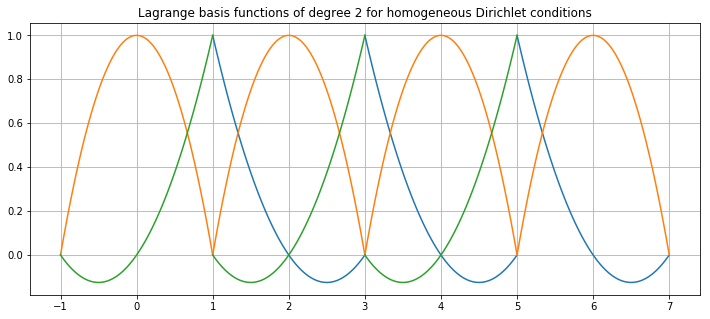

In [3]:
fig,ax = plt.subplots(figsize=(12, 5))

for i in range(shapefun.d + 1):
    
    if i == 0:
        ax.plot(svec + 2, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 6, shapefun.eta[i](svec), color='C' + str(i))
    elif i == shapefun.d:
        ax.plot(svec, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 2, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, shapefun.eta[i](svec), color='C' + str(i))
    else:
        ax.plot(svec, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 2, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 4, shapefun.eta[i](svec), color='C' + str(i))
        ax.plot(svec + 6, shapefun.eta[i](svec), color='C' + str(i))
    
    
ax.grid()
ax.set(title='Lagrange basis functions of degree ' 
               + str(shapefun.d) + ' for homogeneous Dirichlet conditions')

plt.show()

Table 2: <b>Periodic boundary conditions</b> ($bcs = 1$), $\quad N_0 = N_\tn{el}d$.

$$
 \begin{array}{c|c|c}
 \tn{element} & \tn{basis\,function} & \tn{shape\, function}
 \\[0mm]
 k & i & n
 \\[1mm] \hline
 1 & 0,\ldots, d & 0,\ldots,d 
 \\[1mm]
 2 & d,\ldots, 2d & 0,\ldots,d
 \\[1mm]
 \vdots & \vdots & \vdots
 \\[1mm]
 k & (k-1)d,\ldots, kd & 0,\ldots,d
 \\[1mm]
 \vdots & \vdots & \vdots
 \\[1mm]
 N_\tn{el} & (N_\tn{el} - 1)d,\ldots, N_\tn{el}d - 1,\, 0 & 0,\ldots,d 
 \end{array}\,.
$$

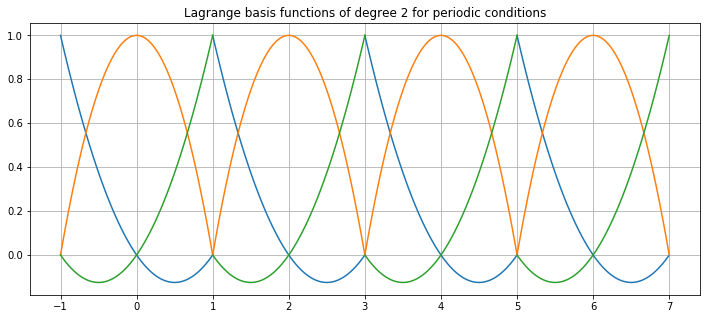

In [2]:
fig,ax = plt.subplots(figsize=(12, 5))

for i in range(shapefun.d + 1):

    ax.plot(svec, shapefun.eta[i](svec), color='C' + str(i))
    ax.plot(svec + 2, shapefun.eta[i](svec), color='C' + str(i))
    ax.plot(svec + 4, shapefun.eta[i](svec), color='C' + str(i))
    ax.plot(svec + 6, shapefun.eta[i](svec), color='C' + str(i))
    
    
ax.grid()
ax.set(title='Lagrange basis functions of degree ' 
               + str(shapefun.d) + ' for periodic conditions')

plt.show()

Any function $E_h \in V_0$ can be expanded in the basis $(\varphi^0_i)_{1\leq i\leq N_0}$. Supposing that $E_h$ is time dependent, we write 

$$
\be
 E_h(t,x) = \sum_{i=1}^{N_0} e_i(t)\, \varphi^0_i(x)\,.   \label{def:Eh}
\ee
$$

Here, the vector $\bold e = (e_i)_{1\leq i\leq N_0} \in \RR^{N_0}$ holds the (time dependent) coefficients with respect to the basis. We shall introduce the node vector $\bold x =(x_i)_{0\leq i\leq N_0+1}\in \RR^{N_0+2}$, holding the domain boundaries $x_0 = a$ and $x_{N_0+1} = b$ as well as the nodes that define the Lagrange basis functions, hence $\varphi^0_i(x_j) = \delta_{i,j}$ for $1\leq i\leq N_0$. The element boundaries $ (c_k)_{1\leq k\leq N_\tn{el}-1}$ are obviously a subset of the elements of $\bold x$. From \eqref{def:Eh} it follows that $E_h(t, x_j) = e_j(t)$. 

Going back to our diagram, the first projector $\Pi_0$ will be just the <b>Lagrange interpolation</b>: 

$$
\be
 \Pi_0: H^1_0 \to V_0,\quad \tn{defined\ by}\quad (\Pi_0E)(x_i) = E(x_i)\quad \forall\ i \in \{1,\ldots,N_0 \} \,.
\ee
$$

Denoting $\Pi_0 E = E_h$ we have $E_h(x_j) = e_j = E(x_j)$. Remark that it makes sense to evaluate $E\in H_0^1$ at any point $x\in (a,b)$ because $E$ is continuous.

### Lagrange histopolation 

Let us now consider the space $V_1 \subset L^2$. Its elements are piece-wise continuous functions. A basis will be once again defined from shape functions on the reference element $I = [-1, 1]$. Taking the same knot sequence $s_0 = -1 < \ldots < s_d = 1 \in I$ as for the Lagrange polynomials defined by \eqref{def:Lag}, the <i>Lagrange histopolation polynomials</i> (LHPs) $\chi_{n+1/2}$ are defined by 

$$
\be \label{def:chi}
 \int_{s_m}^{s_{m+1}}\chi_{n+1/2}(s)\,\tn d s = \delta_{n,m}\,,\qquad n,m = 0,\ldots d-1\,.
\ee
$$

In order to solve these equations we introduce polynomials $\Phi_{n+1/2}$ of degree $d$ such that $\chi_{n+1/2} = \ds{}\Phi_{n+1/2}$. Performing integration in \eqref{def:chi} then yields

$$
\be
 \Phi_{n+1/2}(s_{m+1}) - \Phi_{n+1/2}(s_m) = \delta_{n,m}\,.
\ee
$$

We can solve these equations by Lagrange interpolation. For $n$ fixed, we have $d$ equations for $d+1$ unknowns. Therefore, we are allowed to add the condition $\Phi_{n+1/2}(s_n) = 0$. This just fixes the constant in $\Phi_{n+1/2}$ and does not influence the result for $\chi_{n+1/2}$. We obtain the equations

$$
\ba
 &\Phi_{n+1/2}(s_n) = 0\,,
 \\[1mm]
 &\Phi_{n+1/2}(s_{n+1}) = 1\,,
 \\[1mm]
 &\Phi_{n+1/2}(s_{m+1}) - \Phi_{n+1/2}(s_m) = \delta_{n,m}\qquad \tn{for}\ m\neq n\,.
\ea
$$

By Lagrange interpolation, the solution is 

$$
\be
 \Phi_{n+1/2}(s) = \sum_{m = n+1}^d \eta_m(s)\,,
\ee
$$

where $\eta_m$ denote the Lagrange shape functions defined above. It follows that the LHPs are given by

$$
\be
 \chi_{n+1/2}(s) = \sum_{m = n+1}^d \ds{} \eta_m(s)\,,\qquad n = 0,\ldots,d-1\,.
\ee
$$

<u> Remark:</u> __The LHPs are linear combinations of first order derivatives of Lagrange polynomials.__

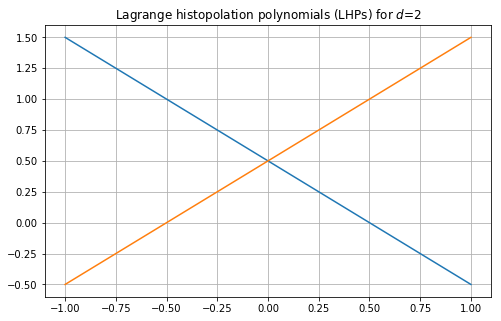

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
svec = np.linspace(-1,1,100)

# initiate the list of LHPs
for i in range(shapefun.d):  
    ax.plot(svec, shapefun.chi[i](svec))
    
ax.grid()
ax.set(title='Lagrange histopolation polynomials (LHPs) for $d$=' + str(shapefun.d))
plt.show()

Let us test the defining property \eqref{def:chi} of LHPs:

$$
\be
\begin{aligned}
 \int_{s_m}^{s_{m+1}}\chi_{n+1/2}(s)\,\tn d s 
 &= \sum_{l = n+1}^d \int_{s_m}^{s_{m+1}}\ds{} \eta_l(s)\,\tn d s
 \\[0mm]
 &= \sum_{l = n+1}^d [ \eta_l(s_{m+1}) - \eta_l(s_m) ]
 \\[2mm]
 &= \eta_{n+1}(s_{m+1}) \underbrace{- \eta_{n+1}(s_m) + \eta_{n+2}(s_{m+1})}_{=0} \underbrace{- \eta_{n+2}(s_m) + \ldots}_{=0} - \eta_{d}(s_m)
 \\[0mm]
 &= \eta_{n+1}(s_{m+1}) - \eta_{d}(s_m)\,.
 \end{aligned}
\ee
$$

Since $m \in\{ 0,\ldots,d-1 \}$ the last term is always zero, which yields the desired result. Let us verify this also numerically:

In [6]:
print('n', 'm', 'delta_nm\n', sep='   ')
for i in range(shapefun.d):
    antider = np.polyint(shapefun.chi[i])
    for j in range(shapefun.d):
        delta_nm = antider(shapefun.s[j + 1]) - antider(shapefun.s[j])
        print(i, j, delta_nm, sep='   ')

n   m   delta_nm

0   0   1.0
0   1   0.0
1   0   0.0
1   1   1.0


The actual basis functions $\varphi_{i+1/2}^1$ are related to the shape functions $\chi_{n+1/2}$ via the mappings $F_k$ from \eqref{F}-\eqref{Finv}. Again, let us clarify the indices:

$$
\ba
 &\tn{elements:} &&\Omega_k, \quad k = 1,\ldots, N_\tn{el} \,,
 \\[2mm]
 &\tn{basis\,functions:} &&\varphi_{i+1/2}^1,\quad i = 0, \ldots, N_1 - 1\,,
 \\[2mm]
 &\tn{shape\,functions:} &&\chi_{n+1/2},\quad n = 0,\ldots, d-1\,.
\ea
$$

The number $N_1$ of LHP basis functions for the space $V_1$ is $d$ per element, hence $N_1 =  N_\tn{el}d$. In the $k$-th element we have the basis functions $\varphi^1_{i+1/2}$ with $i = (k-1)d + n$ with $n = 0,\ldots,d-1$. From this we can deduce the correct indices for relating the basis functions to the shape functions via 

$$
\be
 \chi_{n+1/2}(s) = (\varphi_{i+1/2}^1 \circ F_k)(s)\,,\qquad \tn{where} \quad n = \tn{mod}(i,d)\,.  \label{chi-to-shape}
\ee
$$

<u> Remark:</u> __The basis functions $(\varphi^1_{i+1/2})_{0\leq i\leq N_1-1}$ are linear combinations of $(\pa\varphi^0_i/\pa x)_{1\leq i\leq N_0}$.__

For a basis function defined in the $k$-th element we obtain

$$
\be
 \int_{x_j}^{x_{j+1}} \varphi^1_{i+1/2}(x)\,\tn d x = \frac{c_k - c_{k-1}}{2} \int_{s_m}^{s_{m+1}} \chi_{n+1/2}(s) \,\tn ds = \frac{c_k - c_{k-1}}{2}\,\delta_{n,m}\,.
\ee
$$

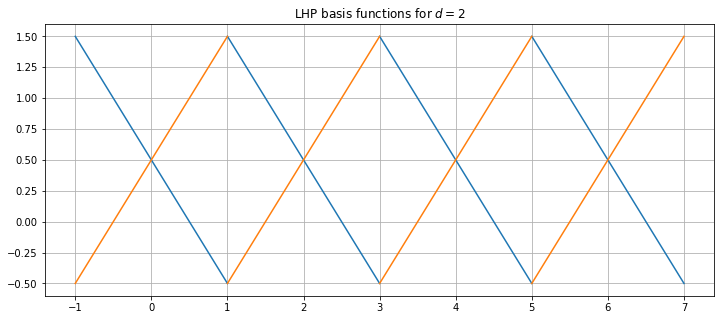

In [7]:
fig,ax = plt.subplots(figsize=(12, 5))

for i in range(shapefun.d):

    ax.plot(svec, shapefun.chi[i](svec), color='C' + str(i))
    ax.plot(svec + 2, shapefun.chi[i](svec), color='C' + str(i))
    ax.plot(svec + 4, shapefun.chi[i](svec), color='C' + str(i))
    ax.plot(svec + 6, shapefun.chi[i](svec), color='C' + str(i))
    
    
ax.grid()
ax.set(title='LHP basis functions for $d=$' + str(shapefun.d))

plt.show()

For $B_h \in V_1$, time-dependent, we write

$$
\be
 B_h(t, x) = \sum_{i=0}^{N_1-1} b_{i+1/2}(t)\, \varphi^1_{i+1/2}(x)\,.   \label{def:Bh}
\ee
$$

For $[x_j,x_{j+1}] \in \Omega_k$ it follows that

$$
\be
 \int_{x_j}^{x_{j+1}} B_h(t, x)\,\tn d x = \frac{c_k - c_{k-1}}{2}\,b_{j+1/2}(t)\,.
\ee
$$

As the second projector in our diagram we choose the <b>Lagrange histopolation</b>:

$$
\be
 \Pi_1: L_2 \to V_1,\quad \tn{defined\ by}\quad \int_{x_i}^{x_{i+1}}(\Pi_1B)(x)\,\tn d x = \int_{x_i}^{x_{i+1}} B(x)\,\tn d x\quad \forall\ i \in \{0,\ldots,N_0\} \,.
\ee
$$

Remark that these integrals are well defined because $B$ is piece-wise continuous. Denoting $\Pi_1B = B_h$ from equation \eqref{def:Bh}, the above definition of the Lagrange histopolant yields

$$
\be \label{Pi1:coeffs}
 \frac{c_k - c_{k-1}}{2}\,b_{j+1/2} = \int_{x_j}^{x_{j+1}} B(x)\,\tn d x\qquad \tn{for}\quad [x_j,x_{j+1}] \in \Omega_k \,.
\ee
$$


### Commuting diagram property

Let us now prove that, with the projections defined above, the diagram

<img src="pics/deRham1D.png" width="220"/>

is indeed a commuting diagram. For this take a function $E\in H^1_0$ and project it to $V_0$, yielding $E_h = \Pi_0 E$. Now we take the derivative of $E_h$ expanded in the basis $(\varphi_i^0)_{1\leq i\leq N_0}$:

$$
\be
 \pder{}{x} (\Pi_0E)(x) = \sum_{i=1}^{N_0} e_i\,  \pder{}{x}\varphi^0_i(x)\,.   
\ee
$$

Since we know that the basis functions $(\varphi^1_{i+1/2})_{0\leq i\leq N_1-1}$ of $V_1$ are linear combinations of $(\pa\varphi^0_i/\pa x)_{1\leq i\leq N_0}$, we can be sure that $\pder{}{x}(\Pi_0E) \in V_1$. Hence,

$$
\be
 \pder{}{x} (\Pi_0E)(x) = \sum_{i=0}^{N_1-1} e'_{i+1/2}\,  \varphi^1_{i+1/2}(x)\,.  
\ee
$$

The coefficients $e'_{i+1/2}$ are uniquely determined via equation \eqref{Pi1:coeffs:}:

$$
\be \label{comm:proof1}
\begin{aligned}
 e'_{i+1/2} &= \frac{2}{c_k - c_{k-1}}\int_{x_i}^{x_{i+1}} \pder{}{x} (\Pi_0E)(x)\,\tn d x 
 \\
 &= \frac{2}{c_k - c_{k-1}} \sum_{j=0}^{N_0-1} e_j \int_{x_i}^{x_{i+1}} \pder{}{x}\varphi^0_j(x)\,\tn d x 
 \\
 &= \frac{2}{c_k - c_{k-1}} \sum_{j=0}^{N_0-1} e_j\, [ \varphi^0_j(x_{i+1}) - \varphi^0_j(x_i) ]
 \\[1mm]
 &= \frac{2}{c_k - c_{k-1}} (e_{i+1} - e_i) \qquad \tn{for}\quad [x_i,x_{i+1}] \in \Omega_k\,.
\end{aligned}
\ee
$$

Remark that for Dirichlet conditions we have $e_0 = e_{N_1} = 0$.
On the other hand, let us project $\pder{}{x} E\in L^2$ to $V_1$, yielding

$$
\be
 \Pi_1 \pder{}{x} E(x)  = \sum_{i=0}^{N_1-1} f_{i+1/2}(t)\,  \varphi^1_{i+1/2}(x)\,,
\ee
$$

where by definition of $\Pi_1$ the coefficients $f_{i+1/2}$ are given by

$$
\be \label{comm:proof2}
\begin{aligned}
 f_{i+1/2} &= \frac{2}{c_k - c_{k-1}}\int_{x_1}^{x_{i+1}} \pder{}{x} E (x)\,\tn d x 
 \\[1mm]
 &= \frac{2}{c_k - c_{k-1}} (E(x_{i+1}) - E(x_i))
 \\[3mm]
 &= \frac{2}{c_k - c_{k-1}} (e_{i+1} - e_{i})\qquad \tn{for}\quad [x_i,x_{i+1}] \in \Omega_k\,.
\end{aligned}
\ee
$$

By comparison of \eqref{comm:proof1} and \eqref{comm:proof2} we prove that

$$
\be
 \pder{}{x} \Pi_0 E = \Pi_1 \pder{}{x} E\,,
\ee
$$

and hence the diagram is commuting.


### Faraday's law (strong)

Let us come back to the discrete system \eqref{disc:1} - \eqref{disc:3}. In what follows we assume uniform grid spacing for simplicity, thus $c_k - c_{k-1} = \Delta x$ for all $k$. Faraday's law is satisfied in a strong sense because we did not integrate by parts. This means that we can write the equation directly for each of the coefficients in the basis of $V_1$. Let us derive this nevertheless from the weak formulation. In 

$$
 \be  \label{Faraday:disc}
 \int_a^b \pder{B_h}{t} C_h\,\tn d x + \int_a^b \pder{E_h}{x} C_h\,\tn d x = 0 \qquad \forall\, C_h \in V_1\,,
 \ee
$$

we write

$$
\be
 B_h(t,x) = \sum_{i=0}^{N_1-1} b_{i+1/2}(t)\, \varphi^1_{i+1/2}(x)\,, \qquad  C_h(x) = \sum_{i=0}^{N_1-1} c_{i+1/2}\, \varphi^1_{i+1/2}(x)\,. 
\ee
$$

with $\bold b = (b_{i+1/2})_{0\leq i\leq N_1 -1} \in \RR^{N_1}$, $\bold c = (c_{i+1/2})_{0\leq i\leq N_1 -1} \in \RR^{N_1}$, and

$$
\be
 E_h(t,x) = \sum_{i=1}^{N_0} e_i(t)\, \varphi^0_i(x)\,,\qquad \pder{E_h}{x}(t,x)= \frac{2}{\Delta x}\sum_{i=0}^{N_1-1} [e_{i+1}(t) - e_i(t)]\, \varphi^1_{i+1/2}(x)\,,
\ee
$$

where $e_0 = e_{N_1} = 0$ and $\bold e = (e_i)_{1\leq i\leq N_0}\in\RR^{N_0}$. Inserted into \eqref{Faraday:disc} this yields

$$
\be
 \sum_{i,j=0}^{N_1-1} \dt{b_{i+1/2}}\,c_{j+1/2} \underbrace{\int_a^b \varphi^1_{i+1/2}\,\varphi^1_{j+1/2} \,\tn d x}_{= M^1_{i,j}} + \frac{2}{\Delta x} \sum_{i,j=0}^{N_1-1} [e_{i+1} - e_i]\,c_{j+1/2} \underbrace{\int_a^b \varphi^1_{i+1/2}\,\varphi^1_{j+1/2} \,\tn d x}_{= M^1_{i,j}} = 0 \,.
\ee
$$

Introducing the gradient matrix $\GG \in \RR^{N_1 \times N_0}$,

$$
\be
 \GG := \frac{2}{\Delta x}\begin{pmatrix}
 1 &   &  &  &  & 
 \\
 -1 & 1 &  & &  & 
 \\
  & -1 & 1 &   &  & 
 \\
  &  & \ddots & \ddots &  & 
 \\
  & &  & -1 & 1 & 
 \\
  &  &  & & -1 & 1
 \\
  &  &  &  &  & -1  
 \end{pmatrix}\,,
\ee
$$

and the mass matrix $\MM^1 = (M^1_{i,j})_{0\leq i,j,\leq N_1-1} \in \RR^{N_1 \times N_1}$, we can write this compactly as

$$
\be
 \dt{\bold b^\top}\, \MM^1\, \bold c + (\GG\,\bold e)^\top \,\MM^1\, \bold c = 0 \,.
\ee
$$

Since this is true for all $\bold c \in \RR^{N_1}$ we obtain

$$
\be
 \dt{\bold b} + \GG\,\bold e = 0 \,.
\ee
$$

This form is independent of the chosen polynomial degree.

### Ampère's law ($y$-component, weak)

Let us now consider the $y$-component of Ampère's law:

$$
\be \label{Ampere2:disc}
\frac{1}{c^2} \int_a^b \pder{E_h}{t} F_h\,\tn d x - \int_a^b B_h\,\pder{F_h}{x} \,\tn d x = - \mu_0 \int_a^b  J \,F_h\,\tn d x \qquad \forall\, F_h \in V_0\,.
\ee
$$

We write 

$$
\be
 F_h(x) = \sum_{i=1}^{N_0} f_i\, \varphi^0_i(x)\,,\qquad \pder{F_h}{x}(x)= \frac{2}{\Delta x} \sum_{i=0}^{N_1-1} [f_{i+1} - f_i]\, \varphi^1_{i+1/2}(x)\,,
\ee
$$

with $\bold f = (f_i)_{1\leq i\leq N_0} \in \RR^{N_0}$ and define

$$
\be
 \bold j = (j_i)_{1\leq i\leq N_0} \in \RR^{N_0}\qquad \tn{with} \quad j_i(t) := \int_a^b  J(t,x) \,\varphi^0_i(x)\,\tn d x\,,\quad \,.
\ee
$$

Inserting this into \eqref{Ampere2:disc} yields

$$
\be
\begin{aligned}
 &\frac{1}{c^2} \sum_{i,j=1}^{N_0} \dt{e_i}\, f_j \underbrace{\int_a^b \varphi^0_i\,\varphi^0_j\,\tn d x}_{=M^0_{i,j}} - \frac{2}{\Delta x} \sum_{i,j=0}^{N_1-1} b_{i+1/2}[f_{j+1} - f_j] \underbrace{\int_a^b  \varphi^1_{i+1/2}\,\varphi^1_{j+1/2} \,\tn d x}_{=M^1_{i,j}}= - \mu_0 \sum_{i=1}^{N_0} j_i\,f_i \,.
\end{aligned}
\ee
$$

Introducing the mass matrix $\MM^0 = (M_{i,j}^0)_{1\leq i,j\leq N_0} \in \RR^{N_0\times N_0}$, we can write this compactly as

$$
\be
 \frac{1}{c^2} \dt{\bold e^\top}\, \MM^0\, \bold f - \bold b^\top\, \MM^1 \GG\, \bold f 
  = - \mu_0\, \bold j^\top \, \bold f\qquad \forall\ \bold f \in \RR^{N_0} \,.
\ee
$$

Canceling $\bold f$ leads to the linear system

$$
\be
 \frac{1}{c^2} \MM^0 \dt{\bold e} -  \GG^\top \MM^1 \bold b 
  = - \mu_0\, \bold j \,.
\ee
$$

### Ampère's law ($x$-component, strong) and Gauss' law (strong)

The $x$-component of Ampère's law \eqref{disc:1} is given in strong form, hence

$$
\be
 \frac{1}{c^2}\dt{\bold e_x} = -\mu_0\,\bold j_x\,,
\ee
$$

where $\bold e_x = (e_{x,i})_{0\leq i\leq N_0} \in \RR^{N_0+1}$ and $\bold j_x = (j_{x,i})_{0\leq i\leq N_0} \in \RR^{N_0+1}$ are the coefficients in the basis of $\tilde V_0$ (the 'tilde' indicates periodic boundary conditions), denoted $(\tilde \varphi^0_i)_{0\leq i\leq N_0}$. In particular

$$
\ba
 E_{x,h}(t,x) &= \sum_{i=0}^{N_0} e_{x,i}(t)\,\tilde \varphi^0_i(x)\,,
 \\
 J_{x,h}(t,x) &= \sum_{i=0}^{N_0} j_{x,i}(t)\,\tilde \varphi^0_i(x)\,,\qquad j_{x,i}(t) = J_x(t,x_i)\,.
\ea
$$

The discrete Gauss law \eqref{disc:4} reads

$$
\be
 \int_a^b \pder{E_{x,h}}{x} D_h \,\tn d x = \frac{1}{\eps_0} \int_a^b (\Pi_1\varrho)\,D_h\,\tn d x \qquad \forall\, D_h \in V_1\,.
\ee
$$

Here,

$$
\be
 \pder{E_{x,h}}{x}(t,x) = \sum_{i=0}^{N_0} e_{x,i}(t)\,\pder{}{x}\tilde \varphi^0_i(x) = \sum_{i=0}^{N_1-1} e'_{x,i+1/2}(t)\,\varphi_{i+1/2}^1(x)\,,
\ee
$$

because the basis functions of $V_1$ are linear combinations of the first order derivatives of the basis functions of $\tilde V_0$. Moreover, the projected charge density reads

$$
\be
\begin{aligned}
 &(\Pi_1\varrho)(t,x) = \sum_{i=0}^{N_1-1} \varrho_{i+1/2}(t)\,\varphi_{i+1/2}^1(x)\,,
 \\[1mm]
 & \tn{where}\quad \varrho_{i+1/2}(t) = \frac{2}{c_k - c_{k-1}}\int_{x_i}^{x_{i+1}} \varrho(t,x)\,\tn d x\qquad \tn{for}\quad [x_i,x_{i+1}] \in \Omega_k\,.
\end{aligned}
\ee
$$

We introduce the gradient matrix $\tilde \GG \in \RR^{N_1 \times N_0+1}$ for periodic functions,

$$
\be
 \tilde\GG := \begin{pmatrix}
 -1 & 1  &  &  &  
 \\
  & -1 & 1 & &   
 \\
  &  & \ddots & \ddots &  
 \\
  &  &   & -1 & 1 
 \\
  1 &  &  &    & -1  
 \end{pmatrix}\,,
\ee
$$

in order to write the discrete Gauss law as

$$
\be
 \frac{1}{c^2} \tilde \GG\, \bold e_x  = \frac{ \boldsymbol \varrho}{\eps_0} \,.
\ee
$$

### Summary: discrete 1D Maxwell equations

In summary, the system \eqref{disc:1} - \eqref{disc:3} for the coefficients $\bold e_x\in \RR^{N_0+1}$, $(\bold e, \bold b) \in \RR^{N_0}\times \RR^{N_1}$ reads

$$
\ba
 & \frac{1}{c^2}\dt{\bold e_x} = -\mu_0\,\bold j_x\,,  \label{summary1D:1}
 \\[1mm]
 & \frac{1}{c^2} \MM^0 \dt{\bold e} -  \GG^\top \MM^1 \bold b 
  = - \mu_0\, \bold j\,,
 \\[1mm]
 & \dt{\bold b} + \GG\,\bold e = 0\,,
 \\[2mm]
 & \tilde \GG\, \bold e_x  = \frac{\boldsymbol \varrho}{\eps_0} \,.  \label{summary1D:4}
\ea
$$

Applying the matrix $\tilde \GG$ to the first equation and inserting Gauss law yields

$$
\be \label{charge:disc}
 \dt{\boldsymbol \varrho} + \tilde \GG\,\bold j_x = 0\,,
\ee
$$

which is the discrete conservation of charge. On the other hand, taking the time derivative of the discrete Gauss law \eqref{summary1D:4} leads to

$$
\be  \label{hold:1}
 \dt{} \left( \tilde \GG\, \bold e_x  - \frac{\boldsymbol \varrho}{\eps_0} \right) = - \frac{1}{\eps_0}\tilde \GG\, \bold j_x - \frac{1}{\eps_0} \dt{\boldsymbol \varrho} = 0\,.
\ee
$$

This means that the discrete Gauss law holds at all times provided it holds at the initial time. It is interesting to note that \eqref{charge:disc} corresponds to the projection of the exact charge conservation law \eqref{charge} on the discrete space $V_1$:

$$
\be  \label{hold:2}
 0 = \Pi_1 \left(\pder{\varrho}{t} +  \pder{\bold J}{x}  \right) = \pder{(\Pi_1 \varrho)}{t} + \pder{}{x} (\Pi_0 \bold J)\,. 
\ee
$$

This is a consequence of the commuting diagram property.

## Coupling to a particle-in-cell (PIC) solver 

### Some PIC fundamentals

Maxwell's equations are coupled to the plasma by means of the charge density $\varrho$ and the current density $\bold J$. The plasma dynamics can be described for example by Vlasov equations for each particle species $s$:

$$
\be
\left\{
\begin{aligned}
 &\,\pder{}{t}\, f_s + \bold v \cdot \nabla_x f_s + \frac{q_s}{m_s}(\bold E + \bold v \times \bold B)\cdot \nabla_v f_s = Q(f_s)\,,
 \\[1mm]
 &\,f_s(t = t_\tn{in}) = f_{s,\tn{in}}(\bold x, \bold v)\,.
\end{aligned}
\right.
\ee
$$

Here, $f_s = f_s(t,\bold x, \bold v)$ is the particle distribution function of species $s$, $\bold x$ stands for the particle position, $\bold v$ denotes the particle velocity, $q_s$ and $m_s$ denote the species' charge and mass, respectively, $Q$ is a collision operator and $f_\tn{in}$ stands for an initial condition. The charge and current densities are defined by

$$
\ba
 \varrho(t,\bold x) &:= \sum_s q_s \int_{\RR^3} f_s(t,\bold x,\bold v)\,\tn d^3\bold v\,,
 \\[1mm]
 \bold J(t,\bold x) &:= \sum_s q_s\int_{\RR^3} \bold v\, f_s(t,\bold x,\bold v)\,\tn d^3\bold v\,.
\ea
$$

In our 1D test case we consider only variations with respect to $x$, $v_x$ and $v_y$, hence $f_s = f_s(t,x,v_x,v_y)$. We also work in the collision-less case, $Q = 0$, and assume periodic boundary conditions in $x$. Moreover, $E_z = B_x = B_y = 0$ has been assumed, such that

$$
\be \label{Vlasov:1d2v}
\left\{
\begin{aligned}
 &\,\pder{}{t}\, f_s + v_x \pder{}{x} f_s + \frac{q_s}{m_s}(E_x + v_y B) \pder{}{v_x} f_s + \frac{q_s}{m_s}(E - v_x B) \pder{}{v_y} f_s = 0
 \\[1mm]
 &\,f_s(t = t_\tn{in}) = f_{s,\tn{in}}(x,v_x,v_y)\,.
\end{aligned}
\right.
\ee
$$

We will solve the Vlasov equation \eqref{Vlasov:1d2v} by means of a particle-in-cell (PIC) 
method with control variate. In a PIC method, the distribution function is approximated by a sum of Dirac masses,

$$
\be  \label{def:fN}
 f_{s,N}(t, x, v_x, v_y) = \sum_{p=1}^{N_p} w_p^0\, \delta(x_p(t) - x)\,\delta(v_{x,p}(t) - v_x)\, \delta(v_{y,p}(t) - v_y)\,,
\ee
$$

where $p=1,\ldots,N_p$ indicates a so-called marker and $w_p^0$ denotes the marker's weight, which will be specified later. The marker trajectories satisfy the characteristic equations of \eqref{Vlasov:1d2v}:

$$
\ba
 \dt{x_p} &= v_{x,p} && x_p(t_0) = x_p^0\,, \label{chars:1}
 \\[1mm]
 \dt{v_{x,p}} &= \frac{q_s}{m_s}[E_x(t,x_p) + v_{y,p} B(t,x_p)] && v_{x,p}(t_0) = v_{x,p}^0\,,
 \\[1mm]
 \dt{v_{y,p}} &= \frac{q_s}{m_s}[E(t,x_p) - v_{x,p} B(t,x_p)] && v_{y,p}(t_0) = v_{y,p}^0\,.  \label{chars:3}
\ea
$$

In FEEC, the sum of Dirac masses in \eqref{def:fN} is problematic, because the projectors $\Pi_0$ and $\Pi_1$ are not well defined for the corresponding charge and current densities. In order to make the projections well-defined we need to smooth these quantities. For this, we introduce a positive smoothing kernel $S = S(x) \geq 0$, which is normalized, $\int_\RR S(x)\,\tn d x = 1$, symmetric, $S(-x) = S(x)$ and has compact support. We apply it to the quantities to be projected, $J_x$ and $\varrho$ in our case, and define

$$
\ba
  \varrho_N (t,x) &:= \sum_s q_s \int_\RR \int_{\RR^2} S(x' - x) \,
   f_{s,N}(t,x',v_x,v_y)\,\tn d v_x\, \tn d v_y\, \tn d x' 
   \\[0mm]
   &\ = \sum_s q_s \sum_{p=1}^{N_p} w_p^0\, S(x_p(t) - x)\,,  \nonumber
 \\[1mm]
  J_{x,N} (t,x) &:= \sum_s q_s \int_\RR \int_{\RR^2} S(x' - x) \,v_x 
 \, f_{s,N}(t,x',v_x,v_y)\,\tn d v_x\, \tn d v_y\, \tn d x' 
   \\[0mm]
   &\ = \sum_s q_s \sum_{p=1}^{N_p} w_p^0\, S(x_p(t) - x)\,v_{x,p}(t)\,.   \nonumber
\ea
$$

Remark that for $S(x) \to \delta(x)$ (Dirac delta distribution) we obtain the non-smoothed quantities. With these definitions, we have conservation of charge:

$$
\be
 \pder{\varrho_N}{t} + \pder{J_{x,N}}{x} = 0\,.
\ee
$$

Applying the projector $\Pi_1$, it follows from the commuting diagram property that this holds also in the discrete case, cf. \eqref{hold:1}-\eqref{hold2}. For the current density in $y$-direction, which is not projected, we keep the conventional expression and define

$$
\be
\begin{aligned}
 J_N (t,x) &:= \sum_s q_s \int_{\RR^2} v_y \, f_{s,N}(t,x,v_x,v_y)\,\tn d v_x\, \tn d v_y 
 \\
 &\ = \sum_s q_s \sum_{p=1}^{N_p} w_p^0\,\delta(x_p(t) - x)\, v_{y,p}(t)\,.  
 \end{aligned}
\ee
$$

The sources $\boldsymbol \varrho = (\varrho_{i+1/2})_{0\leq i\leq N_1-1}$, $\bold j_x = (j_{x,i})_{0\leq i\leq N_0}$ and $\bold j = (j_i)_{0\leq i\leq N_0-1}$ in the discrete Maxwell equations \eqref{summary1D:1}-\eqref{summary:1D:4} are now well-defined:

$$
\ba
 \varrho_{i+1/2}(t) &= \frac{2}{c_k - c_{k-1}}\int_{x_i}^{x_{i+1}} \varrho_N(t,x)\,\tn d x  \label{sources:1}
  \\[1mm]
  &= \frac{2}{c_k - c_{k-1}} \sum_s q_s \sum_{p=1}^{N_p} w_p^0 \int_{x_i}^{x_{i+1}} S(x_p(t) - x)\,\tn d x \qquad \tn{for}\quad [x_i,x_{i+1}] \in \Omega_k\,,   \nonumber
 \\[2mm]
 j_{x,i}(t) &= J_{x,N}(t,x_i) = \sum_s q_s \sum_{p=1}^{N_p} w_p^0\, S(x_p(t) - x_i)\,v_{x,p}(t)\,,
 \\[2mm]
 j_i(t) &= \int_a^b J_N(t,x)\,\varphi_i^0(x)\,\tn d x = \sum_s q_s \sum_{p=1}^{N_p} w_p^0\,\varphi_i^0(x_p(t))\,v_{y,p}(t)\,.   \label{sources:3}
\ea
$$

Remark that the last integral is well-defined because the basis functions $\varphi_i^0$ have compact support (What about the velocity direction?). 

### The weights $w_p^0$

We want to adopt the Monte Carlo approach and interpret the expressions for $\varrho_{i+1/2}$, $j_{x,i}$ and $j_i$ as expectation values of random variables. This enables the use of tools form probability theory, in particular Monte Carlo integration, in the error analysis of the code. Let us introduce probability distribution functions (PDFs) $g_s = g_s(t,x,v_x,v_y)$ which satisfy the Vlasov equation \eqref{Vlasov:1d2v} for some initial state $g_{s,\tn{in}}$. We can write the smoothed sources as

$$
\be
\begin{aligned}
 \begin{pmatrix}
  \varrho_N \\ J_{x,N} 
 \end{pmatrix}(t,x)
 &= \sum_s q_s \int_\RR \int_{\RR^2} S(x' - x) \,
 \begin{pmatrix}
  1 \\ v_x 
 \end{pmatrix}\, \frac{f_s(t,x',v_x,v_y)}{g_s(t,x',v_x,v_y)}\,g_s(t,x',v_x,v_y)\,\tn d v_x\, \tn d v_y\, \tn d x'\,,
\end{aligned}
\ee
$$

and we also write $j_i$ as

$$
\be
 j_i(t) = \sum_s q_s \int_a^b\int_{\RR^2} v_y\,\varphi_i^0(x) \, \frac{f_s(t,x,v_x,v_y)}{g_s(t,x,v_x,v_y)}\, g_s(t,x,v_x,v_y)\,\tn d v_x\, \tn d v_y\,\tn d x \,.
\ee
$$

These integrals can now be interpreted as expectation values $\langle\cdot\rangle$ of functions of the random variables $(X,V_x,V_y)$, distributed according to $g_s$:

$$
\be  \label{expects}
 \begin{pmatrix}
  \varrho_N \\ J_{x,N} \\ j_i
 \end{pmatrix} 
 = \sum_s q_s \left\langle
 \begin{pmatrix}
  S(X - x) \\ V_x\,S(X - x) \\ V_y\,\varphi_i^0(X)
 \end{pmatrix}\, \frac{f_s(t,X,V_x,V_y)}{g_s(t,X,V_x,V_y)}
 \right\rangle \,.
\ee
$$

These expectation values can be estimated by a finite number $N_P$ of realizations of the random variables, called 'markers' $\bold z_p(t) = (x_p(t),v_{x,p}(t),v_{y,p}(t))$, $p = 1,\ldots,N_p$. The markers are drawn as $(x_p^0,v_{x,p}^0,v_{y,p}^0)$ from the PDF $g_{s,\tn{in}}$ at the initial time and then evolved according to the characteristic equations \eqref{chars:1}-\eqref{chars:3}. The estimators for the expectations values \eqref{expects} are the PIC discretizations of the perturbed quantities:

$$
\be  \label{PIC:disc}
 \begin{pmatrix}
  \widehat \varrho_N \\ \widehat J_{x,N} \\ j_i
 \end{pmatrix} 
 := \sum_s q_s \sum_{p=1}^{N_p}
 \begin{pmatrix}
   S(x_p(t) - x) \\ v_{x,p}(t)\, S(x_p(t) - x) \\ v_{y,p}(t)\,\varphi_i^0(x_p(t))
 \end{pmatrix}\,  w_p^0 \,.
\ee
$$

It follows then that $j_{x,i}(t) = \widehat J_{x,N}(t,x_i)$ and similarly for the charge density evaluated at the quadrature points for the integration in \eqref{sources:1}. Here, we used that both $f_s$ and $g_s$ are constant along the characteristics, i.e. the solutions of \eqref{chars:1}-\eqref{chars:3}, such that the so-called 'weights'

$$
\be
 w_p^0 := \frac{1}{N_P} \frac{f_s(t,x_p(t),v_{x,p}(t),v_{y,p}(t))}{g_s(t,x_p(t),v_{x,p}(t),v_{y,p}(t))} = \frac{1}{N_P} \frac{f_{s,\tn{in}}(x_p^0,v_{x,p}^0,v_{y,p}^0)}{g_{s,\tn{in}}(x_p^0,v_{x,p}^0,v_{y,p}^0)} 
\ee
$$

are independent of time, computed for the initial marker states once. 

### The semi-discrete 1D2V Vlasov-Maxwell system 

Let us put together the semi-discrete system we derived thus far. We assume that there is only one particle species and omit the index $s$ (and the sums over $s$) in the following. Provided that the discrete Gauss law $\tilde \GG\, \bold e_x  = \frac{\boldsymbol \varrho}{\eps_0}$ is satisfied at the initial time, the semi-discrete problem reads:

Find $(\bold e_x, \bold e, \bold b, \bold Z) \in \RR^{N_0+1} \times \RR^{N_0} \times \RR^{N_1} \times \RR^{3 N_p}$, where $\bold Z = (\bold z_p)_{1\leq p \leq N_p}$ holds all the marker coordinates in phase space, such that 

$$
\ba
 & \frac{1}{c^2}\dt{\bold e_x} = -\mu_0\,\bold j_x\,,  \label{sys:ex}
 \\[1mm]
 & \frac{1}{c^2} \MM^0 \dt{\bold e} -  \GG^\top \MM^1 \bold b 
  = - \mu_0\, \bold j\,,
 \\[1mm]
 & \dt{\bold b} + \GG\,\bold e = 0\,,
 \\[1mm]
 &\dt{x_p} = v_{x,p}\,, && x_p(t_\tn{in}) = x_p^0\,, 
 \\[1mm]
 &\dt{v_{x,p}} = \frac{q_s}{m_s} \left[\sum_{i=0}^{N_0}e_{x,i}\, S(x_p - x_i) + v_{y,p} B_h(t,x_p) \right]\,, && v_{x,p}(t_\tn{in}) = v_{x,p}^0\,,
 \\[1mm]
 &\dt{v_{y,p}} = \frac{q_s}{m_s} \left[E_h(t,x_p) - v_{x,p} B_h(t,x_p) \right]\,, && v_{y,p}(t_\tn{in}) = v_{y,p}^0\,.  \label{sys:vy}
\ea
$$

In the equations for $v_{x,p}$ the electric field has been replaced by a smoothed version, using the smoothing kernel $S$. This is done for the sake of energy conservation, as demonstrated below.

Let us now show that the following energy is exactly conserved by this discretization:

$$
\be \label{def:Ham}
 H := \frac{\eps_0}{2} \left( \bold e_x^\top \bold e_x + \bold e^\top \MM^0 \bold e \right) + \frac{1}{2\mu_0}\, \bold b^\top \MM^1 \bold b + \sum_s \frac{m_s}{2} \sum_{p=1}^{N_p} w_p^0\, (v_{x,p}^2 + v_{y,p}^2)\,.
\ee
$$

Using that the mass matrices are symmetric, the time derivative can be computed to be

$$
\be
\begin{aligned}
 \dt{H} &= \eps_0 \left( \bold e_x^\top \dt{\bold e_x} + \bold e^\top \MM^0 \dt{\bold e} \right) + \frac{1}{\mu_0}\, \bold b^\top \MM^1 \dt{\bold b}
 + \sum_s  m_s \sum_{p=1}^{N_p} w_p^0 \left(v_{x,p}\dt{v_{x,p}} + v_{y,p} \dt{v_{y,p}} \right)
 \\[1mm]
 &= - \bold e_x^\top \bold j_x - \bold e^\top \bold j + \frac{1}{\mu_0} \bold e^\top \GG^\top \MM^1 \bold b  - \frac{1}{\mu_0}\, \bold b^\top \MM^1 \GG\,\bold e 
 \\[1mm]
 &\quad + \sum_s q_s \sum_{p=1}^{N_p} w_p^0 \left[v_{x,p}\left(\sum_{i=0}^{N_0}e_{x,i}\, S(x_p - x_i) + v_{y,p} B_h \right) + v_{y,p} \left(\sum_{i=0}^{N_0-1}e_i\, \varphi_i^0(x_p) - v_{x,p} B_h \right) \right]
 \\[1mm]
 &= 0\,.
 \end{aligned}
\ee
$$

Here, we used that 

$$
\be
 \bold e_x^\top \bold j_x = \sum_{i=0}^{N_0} e_{x,i} \sum_s q_s \sum_{p=1}^{N_p} w_p^0\, S(x_p - x_i)\,v_{x,p}\,,
\ee
$$

and

$$
\be
\bold e^\top \bold j = \sum_{i=0}^{N_0-1} e_i \sum_s q_s \sum_{p=1}^{N_p} w_p^0\,\varphi_i^0(x_p)\,v_{y,p}\,. 
\ee
$$

## Poisson structure

It is not immediately evident, but the system \eqref{sys:ex}-\eqref{sys:vy} has an underlying geometric structure. To understand this better, let us recall some notions of dynamical systems. Let $I=[t_0,t_1]\subset \RR$ denote a time interval and let $\bold u: I \to \RR^n$ denote an $n$-dimensional dynamical variable. Moreover, let $H: \RR^n \to \RR$ stand for the Hamiltonian of the system and let us denote by $\nabla_{\bold u}H: \RR^n \to \RR^n$ the gradient of the Hamiltonian with respect to the variables $\bold u$. Suppose that the dynamics are given by

$$
\be \label{Hamsys}
 \dt{\bold u} = \JJ(\bold u)\, \nabla_{\bold u} H(\bold u)\,,
\ee
$$

where $\JJ: \RR^n \to \RR^{n\times n}$ is called the __Poisson matrix__ (or Poisson structure). The system \eqref{Hamsys} is called a __Hamiltonian system__ if the following holds:

1. $\JJ(\bold u)$ is skew-symmetric, $\JJ(\bold u)^\top = -\JJ(\bold u)$ for all $\bold u$,


2. $\JJ(\bold u)$ satisfies the __Jacobi identity__:

$$
\be
 \sum_l \left( \pder{\JJ_{i,j}(\bold u)}{u_l}\, \JJ_{l,k}(\bold u) + \pder{\JJ_{j,k}(\bold u)}{u_l}\, \JJ_{l,i}(\bold u) + \pder{\JJ_{k,i}(\bold u)}{u_l}\, \JJ_{l,j}(\bold u) \right) = 0 \qquad \forall \ i,j,k\,.
\ee
$$

Because of \eqref{Hamsys}, any functional $F:\RR^n\to\RR$ of $\bold u$ evolves according to

$$
\be
 \dt{}F(\bold u(t)) = \nabla_\bold{u} F^\top(\bold u)\, \dt{\bold u} = \nabla_\bold{u} F^\top(\bold u)\, \JJ(\bold u)\, \nabla_{\bold u} H(\bold u) =: \{F,H\}(\bold u)  \,.
\ee
$$

In the last step we defined the __Poisson bracket__: a bilinear, anti-symmetric operator on functionals, that satisfies the Leibniz rule and a Jacobi identity. Setting $F = H$ and using the skew-symmetry of $\JJ(\bold u)$ yields the conservation of energy. Any function of $H$ is conserved as well. They belong to the so-called __momentum maps__: these are functionals $F$ for which $\{F,H\} = 0$. Moreover, any $F$ with $\nabla_\bold{u}F \in\tn{Ker} \JJ(\bold u)$ is a conserved quantity. These are called __Casimirs__. A numerical scheme that can be written in the form \eqref{Hamsys} is called a Poisson integrator. Such integrators usually have good properties regarding stability and accuracy because of the large amount of conservation laws, which are dynamical constraints that are enforced automatically by the integrator.  

We will now show that the semi-discrete system \eqref{sys:ex}-\eqref{sys:vy} is indeed a Hamiltonian system. For this, let us denote the vector holding the marker positions by $\bold X  = (x_p)_{1\leq p\leq N_p} \in \RR^{N_p}$ and the corresponding vectors for the velocities by $\bold V_x  = (v_{x,p})_{1\leq p\leq N_p}  \in \RR^{N_p}$ and $\bold V_y  = (v_{y,p})_{1\leq p\leq N_p}  \in \RR^{N_p}$, respectively, such that $\bold Z = (\bold X, \bold V_y, \bold V_y)  \in \RR^{3N_p}$. The dynamical variables of the system are 

$$
\be
 \bold u = \begin{pmatrix}
 \bold e_x 
 \\
 \bold e
 \\
 \bold b
 \\
 \bold X
 \\
 \bold V_x
 \\
 \bold V_y
 \end{pmatrix} \in \RR^{N_\tn{tot}}\,,\qquad N_\tn{tot} = (N_0 + 1) + N_0 + N_1 + 3N_p\,.
\ee
$$

Let us introduce the following diagonal matrix:

$$
\be
 \WW = (m\,w_p^0\,\delta_{p,q})_{1\leq p,q\leq N_p}\in \RR^{N_p \times N_p}\,.
\ee
$$

The Hamiltonian \eqref{def:Ham} for a single species can then be written as

$$
\be  \label{Ham:ebz}
 H(\bold u) = \frac{\eps_0}{2} \left( \bold e_x^\top \bold e_x + \bold e^\top \MM^0 \bold e \right) + \frac{1}{2\mu_0}\, \bold b^\top \MM^1 \bold b + \frac{1}{2} \bold V_x^\top \WW\, \bold V_x + \frac{1}{2} \bold V_y^\top \WW\, \bold V_y\,.
\ee
$$

Taking its gradient, we obtain

$$
\be
 \nabla_{\bold u} H(\bold u) = \begin{pmatrix}
 \eps_0 \bold e_x
 \\
 \eps_0 \MM^0 \bold e
 \\
 \frac{1}{\mu_0}\MM^1 \bold b
 \\
 \mathbf 0_{N_p}
 \\
 \WW\,\bold V_x
 \\
 \WW\, \bold V_y
 \end{pmatrix} = \underbrace{\begin{pmatrix}
  \eps_0 \unit_{N_0+1} & & & & & 
  \\
  & \eps_0 \MM^0 & & & &
  \\
  & & \frac{1}{\mu_0} \MM^1 & & &
  \\
  & & & \mathbb 0_{N_p} & &
  \\
  & & & & \WW
  \\
  & & & & & \WW
 \end{pmatrix}}_{=:\HH} \begin{pmatrix}
 \bold e_x 
 \\
 \bold e
 \\
 \bold b
 \\
 \bold X
 \\
 \bold V_x
 \\
 \bold V_y
 \end{pmatrix} = \HH\, \bold u\,.
\ee
$$

Here, the matrix $\HH\in\RR^{N_\tn{tot}\times N_\tn{tot}}$ is block diagonal, $\unit_{N_0+1}\in\RR^{(N_0+1)\times(N_0+1)}$ is the unit matrix, $\mathbb 0_{N_p}\in\RR^{N_p \times N_p}$ denotes a matrix full of zeros and $\mathbf 0_{N_p} \in \RR^{N_p}$ is a vector full of zeros. Remark that the Hamiltonian can now be written as

$$
\be  \label{Ham:u}
 H(\bold u) = \frac{1}{2} \bold u^\top \HH\,\bold u\,.
\ee
$$

In order to write the Poisson structure, we introduce the following matrices:

$$
\ba
 \SS &= (S_{i,p})_{0\leq i \leq N_0,\, 1\leq p \leq N_p} \in \RR^{(N_0+1)\times N_p}, && \tn{with}\quad S_{i,p} := S(x_i - x_p)
 \\[2mm]
 \QQ^0 &= (Q^0_{i,p})_{1\leq i \leq N_0,\, 1\leq p \leq N_p} \in \RR^{N_0\times N_p}, && \tn{with}\quad Q^0_{i,p} := \varphi^0_i(x_p)\,,
 \\[2mm]
 \QQ^1 &= (Q^1_{i,p})_{1\leq i \leq N_1,\, 1\leq p \leq N_p} \in \RR^{N_1\times N_p}, && \tn{with}\quad Q^1_{i,p} := \varphi^1_i(x_p)\,,
\ea
$$

as well as the diagonal matrix

$$
\be
 \BB = (B_{p,q}\,\delta_{p,q})_{1\leq p,q \leq N_p} \in \RR^{N_p\times N_p}, \qquad \tn{with}\quad B_{p,p} := (\QQ^1)^\top \bold b \,.
\ee
$$

With this the system \eqref{sys:ex}-\eqref{sys:vy} can be written as

$$
\ba
 & \dt{\bold e_x} = -\frac{1}{\eps_0}\frac{q}{m}\SS\,\WW\,\bold V_x \,,  
 \\[1mm]
 & \dt{\bold e} = - \frac{1}{\eps_0}\frac{q}{m}(\MM^0)^{-1}\QQ^0\,\WW\,\bold V_y + \frac{1}{\eps_0} (\MM^0)^{-1}\GG^\top \frac{1}{\mu_0} \MM^1 \bold b  \,,
 \\[1mm]
 & \dt{\bold b} = - \frac{1}{\eps_0} \GG\,(\MM^0)^{-1}\eps_0 \MM^0\bold e \,,
 \\[1mm]
 &\dt{\bold X} = \WW^{-1} \WW\,\bold V_x\,,  
 \\[1mm]
 &\dt{\bold V_x} = \frac{q}{m} \left[\frac{1}{\eps_0}\SS^\top \eps_0 \bold e_x + \BB\,\WW^{-1} \WW\,\bold V_y \right]\,, 
 \\[1mm]
 &\dt{\bold V_y} = \frac{q}{m} \left[\frac{1}{\eps_0}(\QQ^0)^\top (\MM^0)^{-1} \eps_0 \MM^0 \bold e - \BB\,\WW^{-1} \WW\,\bold V_x \right]\,.  
\ea
$$

Now we recognize its Poisson structure:

$$
\begin{aligned}
 \underbrace{\dt{}\, \begin{pmatrix}
 \bold e_x 
 \\
 \bold e
 \\
 \bold b
 \\
 \bold X
 \\
 \bold V_x
 \\
 \bold V_y
 \end{pmatrix}}_{\dt{\bold u}} = \underbrace{\begin{pmatrix}
 & & & & -\frac{1}{\eps_0}\frac{q}{m}\SS &
 \\
 & & \frac{1}{\eps_0} (\MM^0)^{-1}\GG^\top & & & - \frac{1}{\eps_0}\frac{q}{m}(\MM^0)^{-1}\QQ^0
 \\
 & - \frac{1}{\eps_0} \GG\,(\MM^0)^{-1} & & & &
 \\
 & & & & \WW^{-1} &
 \\
  \frac{1}{\eps_0}\frac{q}{m} \SS^\top & & & -\WW & & \BB\,\WW^{-1} 
 \\
 & \frac{1}{\eps_0}\frac{q}{m}(\QQ^0)^\top (\MM^0)^{-1} & & & - \BB\,\WW^{-1} &
 \end{pmatrix}}_{= \JJ(\bold u)} \underbrace{\begin{pmatrix}
 \eps_0 \bold e_x
 \\
 \eps_0 \MM^0 \bold e
 \\
 \frac{1}{\mu_0}\MM^1 \bold b
 \\
 \mathbf 0_{N_p}
 \\
 \WW\,\bold V_x
 \\
 \WW\, \bold V_y
 \end{pmatrix}}_{=\nabla_{\bold u} H(\bold u)}
\end{aligned}\,,
$$

where $\JJ \in \RR^{N_\tn{tot} \times N_\tn{tot}}$ is the Poisson matrix. This is written compactly as

$$
\be \label{Hamsys}
 \dt{\bold u} = \JJ(\bold u)\,\nabla_{\bold u} H(\bold u) = \JJ(\bold u)\,\HH\,\bold u\,.
\ee
$$

We see immediately that $\JJ$ is skew-symmetric. The proof of the Jacobi identity would require some time and will be left out here. Written like this we immediately see that the Hamiltonian \eqref{Ham:u} is conserved by the motion:

$$
\be
 \dt{} H(\bold u) = \bold u^\top \HH\, \dt{\bold u} = \bold u^\top \HH\, \JJ(\bold u)\,\HH\,\bold u = - \bold u^\top \HH\, \JJ(\bold u)\,\HH\,\bold u = 0\,.
\ee
$$

## Time discretization

In the last section we showed that the FEEC-PIC space discretization of 1d2v Vlasov-Maxwell leads to the Hamiltonian system \eqref{Hamsys}. The aim is now to find an appropriate time integrator that allows us to keep as much of the geometric structure of the problem as possible. We will discuss the average vector field method and the Hamiltonian splitting method. The time interval $I = [t_0,t_1]$ will be split into $N_t$ cells of equal size $\Delta t$. We consider the dynamical variable at the instants $\bold u^n := \bold u(t_n)$, where $t_n = t_0 + n\Delta t$ are the cell interfaces, $n = 0,\ldots,N_t$. We consider one-step methods, written in full generality as

$$
\be
 \bold u^{n+1} = \bold u^n + \Delta t\, F(\bold u^n, \bold u^{n+1}) \,,
\ee
$$

where the method is called implicit if $F$ depends on $\bold u^{n+1}$ and explicit otherwise. The integrator $\Phi_{\Delta t}: \RR^{N_\tn{tot}} \to \RR^{N_\tn{tot}}$ is the discrete analogon of the flow map, defined by

$$
\be
 \bold u^{n+1} = \Phi_{\Delta t}(\bold u^n)\,.
\ee
$$

An integrator is called symplectic, or a Poisson integrator, if it preserves the Poisson structure, meaning

$$
\be
 D\Phi_{\Delta t}^\top(\bold u^n)\,\JJ(\bold u^n)\,D \Phi_{\Delta t}(\bold u^n) = \JJ(\bold u^n)\qquad \forall\ n\,,
\ee
$$

where $D\Phi_{\Delta t}$ denotes the Jacobian of the integrator.


### Average vector field

The average vector field (AVF) method is related to the Cranck-Nicolson method. It leads to exact conservation of energy but is rather expensive because it is implicit, requiring the inversion of a large matrix of size $N_\tn{tot} \times N_\tn{tot}$. In the discrete sense, conservation of energy means $H(\bold u^{n+1}) = H(\bold u^n)$ for all $n$. From the expression \eqref{Ham:u} of the Hamiltonian we obtain

$$
\be
\begin{aligned}
 H(\bold u^{n+1}) - H(\bold u^n) &= \frac{1}{2} (\bold u^{n+1})^\top \HH\,\bold u^{n+1} -   \frac{1}{2} (\bold u^n)^\top \HH\,\bold u^n
 \\[1mm]
 &= \frac{1}{2} (\bold u^{n+1} + \bold u^n)^\top \HH\,(\bold u^{n+1} - \bold u^n)
 \\[1mm]
 &= \frac{\Delta t}{2} (\bold u^{n+1} + \bold u^n)^\top \HH\,F(\bold u^n, \bold u^{n+1})\,.
\end{aligned}
\ee
$$

If we choose 

$$
\be
 F(\bold u^n, \bold u^{n+1}) = \JJ(\bold u^n)\, \HH\,(\bold u^{n+1} + \bold u^n)\,,
\ee
$$

we obtain $H(\bold u^{n+1}) - H(\bold u^n) = 0$. This leads to the implicit method

$$
\be
 \bold u^{n+1} = \bold u^n + \Delta t\, \JJ(\bold u^n)\, \HH\,(\bold u^{n+1} + \bold u^n) \,,
\ee
$$

which yields the integrator

$$
\be
 \bold u^{n+1} = [\unit_{N_\tn{tot}} - \Delta t\,\JJ(\bold u^n)\, \HH ]^{-1} [\unit_{N_\tn{tot}} + \Delta t\,\JJ(\bold u^n)\, \HH ]\,\bold u^n\,.
\ee
$$

This method is very expensive, because at every $n$ we need to invert the large matrix $[\unit_{N_\tn{tot}} - \Delta t\,\JJ(\bold u^n)\, \HH]\in\RR^{N_\tn{tot} \times N_\tn{tot}}$.

### Hamiltonian splitting

We search for less expensive time integrators which preserve some of the Poisson structure. In Hamiltonian splitting, the idea is to keep the full Poisson structure $\JJ(\bold u)$ is each step but split the Hamiltonian. If one can solve each sub-step analytically this yields Poisson integrators, and the composition of Poisson integrators again yields a Poisson integrator. For example, we could split $H$ as

$$
\be
 H = H_E + H_B + H_x + H_y\,,
\ee
$$

where

$$
\ba
 H_E &= \frac{\eps_0}{2} \left( \bold e_x^\top \bold e_x + \bold e^\top \MM^0 \bold e \right) \,,
 \\[1mm]
 H_B &= \frac{1}{2\mu_0}\, \bold b^\top \MM^1 \bold b\,,
 \\[1mm]
 H_x &=  \frac{1}{2} \bold V_x^\top \WW\, \bold V_x \,,
 \\[1mm]
 H_y &=  \frac{1}{2} \bold V_y^\top \WW\, \bold V_y\,.
\ea
$$

This leads to the following four sub problems:

__Problem 1.__ For $t\in[t_n,t_{n+1}]$, 

$$
\be
 \dt{\bold u} = \JJ(\bold u)\,\nabla_\bold{u} H_E(\bold u)\,,
\ee
$$

which can be solved analytically as

$$
\ba
 & \dt{\bold e_x} = 0 &&\Longrightarrow\qquad \bold e_x(t) = \bold e_x^n \,,  
 \\[1mm]
 & \dt{\bold e} = 0 &&\Longrightarrow\qquad \bold e(t) = \bold e^n  \,,
 \\[1mm]
 & \dt{\bold b} = - \frac{1}{\eps_0} \GG\,(\MM^0)^{-1}\eps_0 \MM^0\bold e &&\Longrightarrow\qquad \bold b(t) = \bold b^n - (t-t_n)\, \GG\,\bold e^n \,,
 \\[1mm]
 &\dt{\bold X} = 0 &&\Longrightarrow\qquad \bold X(t) = \bold X^n \,,  
 \\[1mm]
 &\dt{\bold V_x} = \frac{q}{m} \frac{1}{\eps_0}\SS^\top(\bold X) \eps_0 \bold e_x &&\Longrightarrow\qquad \bold V_x(t)= \bold V_x^n + (t-t_n)\,\frac{q}{m} \SS^\top(\bold X^n)\, \bold e_x^n \,, 
 \\[1mm]
 &\dt{\bold V_y} = \frac{q}{m} \frac{1}{\eps_0}(\QQ^0)^\top(\bold X)\, (\MM^0)^{-1} \eps_0 \MM^0 \bold e &&\Longrightarrow\qquad \bold V_y(t) = \bold V_y^n + (t-t_n)\, \frac{q}{m} (\QQ^0)^\top(\bold X^n)\, \bold e^n \,.  
\ea
$$

The corresponding integrator is denoted by

$$
\be
 \bold u(t) = \Phi^E_t(\bold u^n)\,.
\ee
$$


__Problem 2.__ For $t\in[t_n,t_{n+1}]$, 

$$
\be
 \dt{\bold u} = \JJ(\bold u)\,\nabla_\bold{u} H_B(\bold u)\,,
\ee
$$

which can be solved analytically as

$$
\ba
 & \dt{\bold e_x} = 0 &&\Longrightarrow\qquad \bold e_x(t) = \bold e_x^n \,,  
 \\[1mm]
 & \dt{\bold e} = \frac{1}{\eps_0} (\MM^0)^{-1}\GG^\top \frac{1}{\mu_0} \MM^1 \bold b &&\Longrightarrow\qquad \bold e(t) = \bold e^n + \frac{(t-t_n)}{\eps_0} (\MM^0)^{-1}\GG^\top \frac{1}{\mu_0} \MM^1 \bold b^n  \,,
 \\[1mm]
 & \dt{\bold b} = 0 &&\Longrightarrow\qquad \bold b(t) = \bold b^n \,,
 \\[1mm]
 &\dt{\bold X} = 0 &&\Longrightarrow\qquad \bold X(t) = \bold X^n \,,  
 \\[1mm]
 &\dt{\bold V_x} = 0 &&\Longrightarrow\qquad \bold V_x(t) = \bold V_x^n \,, 
 \\[1mm]
 &\dt{\bold V_y} = 0 &&\Longrightarrow\qquad \bold V_y(t) = \bold V_y^n \,.  
\ea
$$

The corresponding integrator is denoted by

$$
\be
 \bold u(t) = \Phi^B_t(\bold u^n)\,.
\ee
$$


__Problem 3.__ For $t\in[t_n,t_{n+1}]$, 

$$
\be
 \dt{\bold u} = \JJ(\bold u)\,\nabla_\bold{u} H_x(\bold u)\,,
\ee
$$

which can be solved analytically as

$$
\ba
 & \dt{\bold e_x} = -\frac{1}{\eps_0}\frac{q}{m}\SS(\bold X)\,\WW\,\bold V_x &&\Longrightarrow\qquad \bold e_x(t) = \bold e_x^n -\frac{1}{\eps_0}\frac{q}{m} (\bold V_x^n)^\top \WW \int_{t_n}^t \SS^\top(\bold X(s))\,\tn d s \,,  
 \\[1mm]
 & \dt{\bold e} = 0 &&\Longrightarrow\qquad \bold e(t) = \bold e^n  \,,
 \\[1mm]
 & \dt{\bold b} = 0 &&\Longrightarrow\qquad \bold b(t) = \bold b^n \,,
 \\[1mm]
 &\dt{\bold X} = (\WW)^{-1} \WW\, \bold V_x &&\Longrightarrow\qquad \bold X(t) = \bold X^n + (t-t_n)\,\bold V_x^n \,,  
 \\[1mm]
 &\dt{\bold V_x} = 0 &&\Longrightarrow\qquad \bold V_x(t) = \bold V_x^n \,, 
 \\[1mm]
 &\dt{\bold V_y} = -\frac{q}{m} \, \BB(\bold b,\bold X)(\WW)^{-1} \WW\,\bold V_x &&\Longrightarrow\qquad \bold V_y(t) = \bold V_y^n - \frac{q}{m} (\bold V_x^n)^\top \WW \int_{t_n}^t \BB^\top(\bold b^n,\bold X(s))\,\tn d s \,.  
\ea
$$

The exact computation of the integrals is not a problem because the integrands are polynomials in $(t-t_n)$. The time integrator of this step is denoted by

$$
\be
 \bold u(t) = \Phi^x_t(\bold u^n)\,.
\ee
$$

__Problem 4.__ For $t\in[t_n,t_{n+1}]$, 

$$
\be
 \dt{\bold u} = \JJ(\bold u)\,\nabla_\bold{u} H_y(\bold u)\,,
\ee
$$

which can be solved analytically as

$$
\ba
 & \dt{\bold e_x} = 0 &&\Longrightarrow\qquad \bold e_x(t) = \bold e_x^n \,,  
 \\[1mm]
 & \dt{\bold e} = - \frac{1}{\eps_0}\frac{q}{m}(\MM^0)^{-1}\QQ^0(\bold X)\,\WW\,\bold V_y &&\Longrightarrow\qquad \bold e(t) = \bold e^n - \frac{(t - t_n)}{\eps_0}\frac{q}{m}(\MM^0)^{-1}\QQ^0(\bold X^n)\,\WW\,\bold V_y^n \,,
 \\[1mm]
 & \dt{\bold b} = 0 &&\Longrightarrow\qquad \bold b(t) = \bold b^n \,,
 \\[1mm]
 &\dt{\bold X} = 0 &&\Longrightarrow\qquad \bold X(t) = \bold X^n \,,  
 \\[1mm]
 &\dt{\bold V_x} = \frac{q}{m} \, \BB(\bold b,\bold X)(\WW)^{-1} \WW\,\bold V_y &&\Longrightarrow\qquad \bold V_x(t) = \bold V_x^n + \frac{q}{m} \, \BB(\bold b^n,\bold X^n)\,\bold V_y^n \,, 
 \\[1mm]
 &\dt{\bold V_y} = 0 &&\Longrightarrow\qquad \bold V_y(t) = \bold V_y^n \,.  
\ea
$$

The corresponding integrator is denoted by

$$
\be
 \bold u(t) = \Phi^y_t(\bold u^n)\,.
\ee
$$


__Splitting schemes:__

The conventional Lie-Trotter splitting is defined by the propagator

$$
\be
 \Phi^L_{\Delta t} := \Phi^y_{\Delta t} \circ \Phi^x_{\Delta t} \circ \Phi^B_{\Delta t} \circ \Phi^E_{\Delta t} \,.
\ee
$$

This yields a first order scheme. The inverse of this propagator reads

$$
\be
 (\Phi^L)^{-1}_{\Delta t} = \Phi^E_{-\Delta t} \circ \Phi^B_{-\Delta t} \circ \Phi^x_{-\Delta t} \circ \Phi^y_{-\Delta t}\,.
\ee
$$

A second order scheme is achieved with the Strang splitting:

$$
\be
 \Phi^S_{\Delta t} := \Phi^L_{\Delta t/2} \circ \left (\Phi^L \right)^{-1}_{-\Delta t/2}\,.
\ee
$$

Explicitly, the Strang propagator reads

$$
\be
 \Phi^S_{\Delta t} = \Phi^y_{\Delta t/2} \circ \Phi^x_{\Delta t/2} \circ \Phi^B_{\Delta t/2} \circ \Phi^E_{\Delta t/2} \circ \Phi^E_{\Delta t/2} \circ \Phi^B_{\Delta t/2} \circ \Phi^x_{\Delta t/2} \circ \Phi^y_{\Delta t/2}\,.
\ee
$$

A fourth order Strang splitting is obtained by

$$
\be
 \Phi^{S4}_{\Delta t} := \Phi^S_{\gamma_1\Delta t} \circ \Phi^S_{\gamma_2\Delta t} \circ \Phi^S_{\gamma_1\Delta t}\,,
\ee
$$

where

$$
\be
 \gamma_1 = \frac{1}{2 - 2^{1/3}}\,,\qquad \gamma_2 = \frac{2^{1/3}}{2 - 2^{1/3}}\,.
\ee
$$

A fourth order method composed of 10 Lie-Trotter propagators reads

$$
\be
 \Phi^{L4}_{\Delta t} := \Phi^L_{a_5 \Delta t} \circ \left (\Phi^L \right)^{-1}_{-b_5\Delta t} \circ \ldots \circ \Phi^L_{a_1 \Delta t} \circ \left (\Phi^L \right)^{-1}_{-b_1\Delta t}\,,
\ee
$$

where

$$
\ba
 & a_1 = b_5 = \frac{146 + 5\sqrt{19}}{540}\,,\qquad a_2 = b_4 = \frac{-2 + 10\sqrt{19}}{135}\,,\qquad a_3 = b_3 = \frac{1}{5}\,,
 \\[1mm]
 & a_4 = b_2 = \frac{-23-20\sqrt{19}}{270}\,,\qquad a_5 = b_1 = \frac{14 - \sqrt{19}}{108}\,.  \nonumber
\ea
$$